# C. Elegans Deconvolution

Deconvolution of multi-channel [C. Elegans](http://bigwww.epfl.ch/deconvolution/bio/) dataset.

**Note**: This example is really only practical when a GPU is present (CPU execution would likely take hours)

**Reference**<br>
D. Sage, L. Donati, F. Soulez, D. Fortun, G. Schmit, A. Seitz, R. Guiet, C. Vonesch, M. Unser<br>
DeconvolutionLab2: An Open-Source Software for Deconvolution Microscopy<br>
Methods - Image Processing for Biologists, 115, 2017.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from flowdec.nb import utils as nbutils 
from skimage import io
from scipy.stats import describe
from skimage.exposure import rescale_intensity, histogram, adjust_gamma
from flowdec import data as fd_data

In [2]:
channels = ['CY3', 'FITC', 'DAPI']
acqs = fd_data.load_celegans()
acqs.keys()

odict_keys(['FITC', 'CY3', 'DAPI'])

In [3]:
acqs['CY3'].shape(), acqs['CY3'].dtype()

({'actual': None, 'data': (104, 712, 672), 'kernel': (104, 712, 672)},
 {'actual': None, 'data': dtype('uint16'), 'kernel': dtype('uint16')})

In [4]:
from scipy.stats import describe
for ch in channels:
    print('Image stats (' + ch + '):', describe(acqs[ch].data.ravel()))

Image stats (CY3): DescribeResult(nobs=49760256, minmax=(215, 2842), mean=999.7357257768127, variance=366893.5949394481, skewness=0.4276883403137024, kurtosis=-1.3198812347654247)
Image stats (FITC): DescribeResult(nobs=49760256, minmax=(209, 2929), mean=661.6911196558153, variance=111310.51265064703, skewness=0.4886892101746819, kurtosis=-0.7464241176109296)
Image stats (DAPI): DescribeResult(nobs=49760256, minmax=(206, 2687), mean=588.6275371252109, variance=87306.64087066457, skewness=0.6127404387738372, kurtosis=-0.37379257220038875)


In [5]:
%%time
import tensorflow as tf
from flowdec import restoration as tfd_restoration

niter = 500
algo = tfd_restoration.RichardsonLucyDeconvolver(n_dims=3).initialize()

# If GPU memory errors occur (which is possible with <= 4G GPU memory), this alternative will avoid padding
# dimensions of images and PSF to dimensions that are powers of 2 and reduce memory utilization
# algo = tfd_restoration.RichardsonLucyDeconvolver(n_dims=3, pad_mode='none').initialize()

# This should take about 4 mins @500 iterations
res = {ch: algo.run(acqs[ch], niter=niter) for ch in channels}

CPU times: user 1min 58s, sys: 1min 54s, total: 3min 53s
Wall time: 3min 51s


## Summary

In [6]:
# Stack and rescale original image and result to RGB with leading z dimension
def to_rgb(acqs):
    return np.stack([rescale_intensity(acqs[ch].data, out_range='uint8').astype('uint8') for ch in channels], axis=-1)

img_acq = to_rgb(acqs)
print('Image shape (z, y, x, c):', img_acq.shape)
print('Image dtype:', img_acq.dtype)
print('Image stats:', describe(img_acq.ravel()))

img_res = to_rgb(res)
print('Result shape (z, y, x, c):', img_res.shape)
print('Result dtype:', img_res.dtype)
print('Result stats:', describe(img_res.ravel()))

Image shape (z, y, x, c): (104, 712, 672, 3)
Image dtype: uint8
Image stats: DescribeResult(nobs=149280768, minmax=(0, 255), mean=52.151963801525994, variance=2064.2467590126857, skewness=1.0867856712234418, kurtosis=0.4845580249925878)
Result shape (z, y, x, c): (104, 712, 672, 3)
Result dtype: uint8
Result stats: DescribeResult(nobs=149280768, minmax=(0, 255), mean=6.257498956597008, variance=52.2800700527821, skewness=4.160757121646963, kurtosis=50.95251581052161)


Show the histograms for the original and deconvolved images:

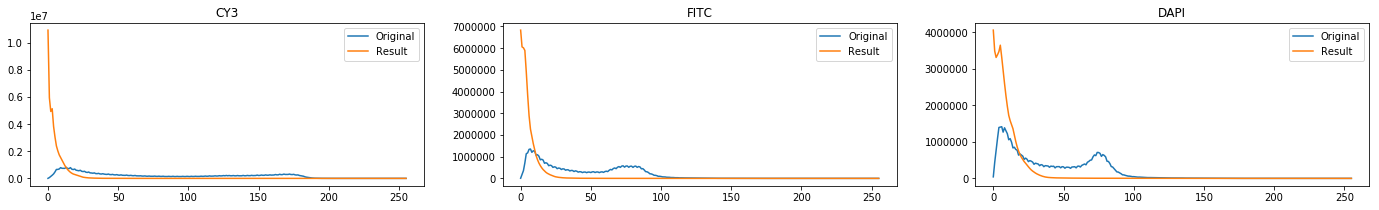

In [7]:
fig, ax = plt.subplots(1, len(channels))
fig.set_size_inches(24, 3)
for i, ch in enumerate(channels):
    ax[i].set_title(ch)
    ax[i].plot(*histogram(img_acq[..., i])[::-1], label='Original')
    ax[i].plot(*histogram(img_res[..., i])[::-1], label='Result')
    ax[i].legend()

## Visualization

Show max-z projections over a z plane slice in the middle of the volume with manually specified contrast settings:

Text(0.5,1,'Deconvolved')

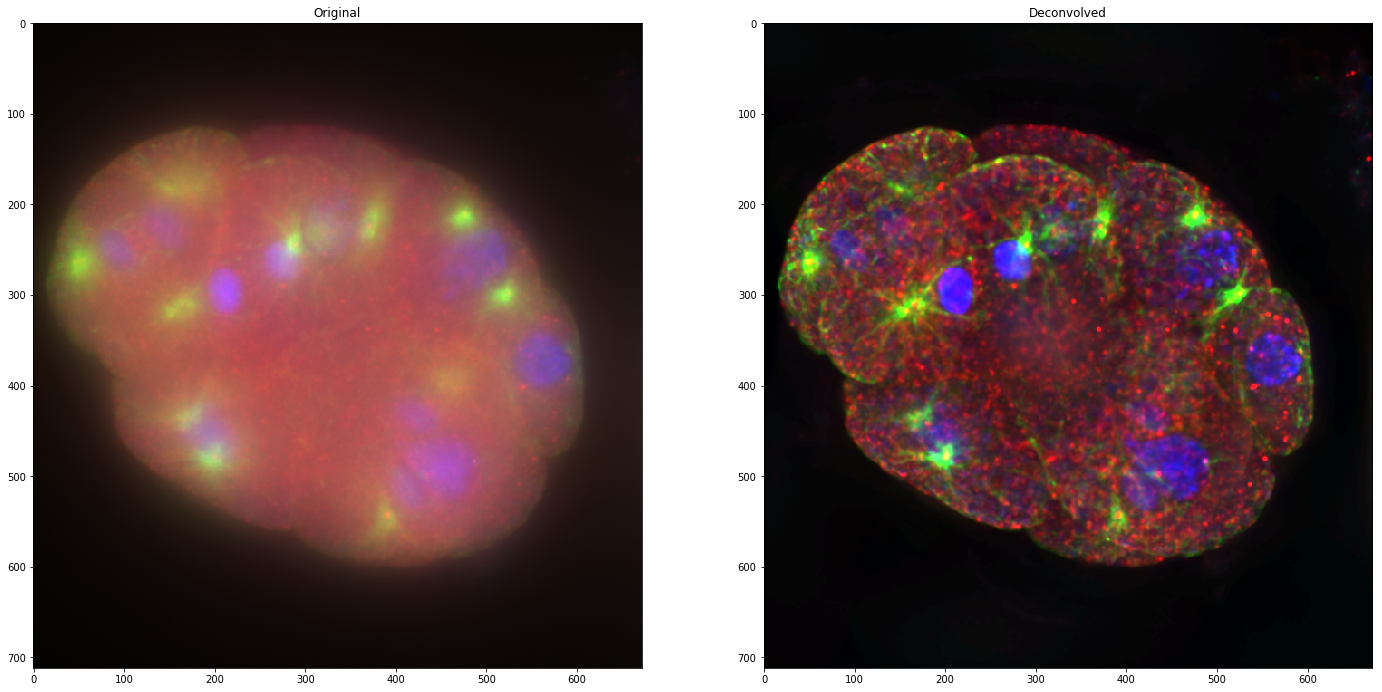

In [8]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((24, 12))

zslice = slice(45, 75)
max_values = {'CY3': 50, 'FITC': 100, 'DAPI': 150}
axs[0].imshow(img_acq[zslice].max(axis=0))
axs[0].set_title('Original')
axs[1].imshow(np.stack([
    rescale_intensity(
        img_res[zslice, ..., i].clip(0, max_values[ch]), 
        out_range='uint8'
    ) for i, ch in enumerate(channels)
], axis=-1).max(axis=0))
axs[1].set_title('Deconvolved')

Show max-z projections for each channel separately:

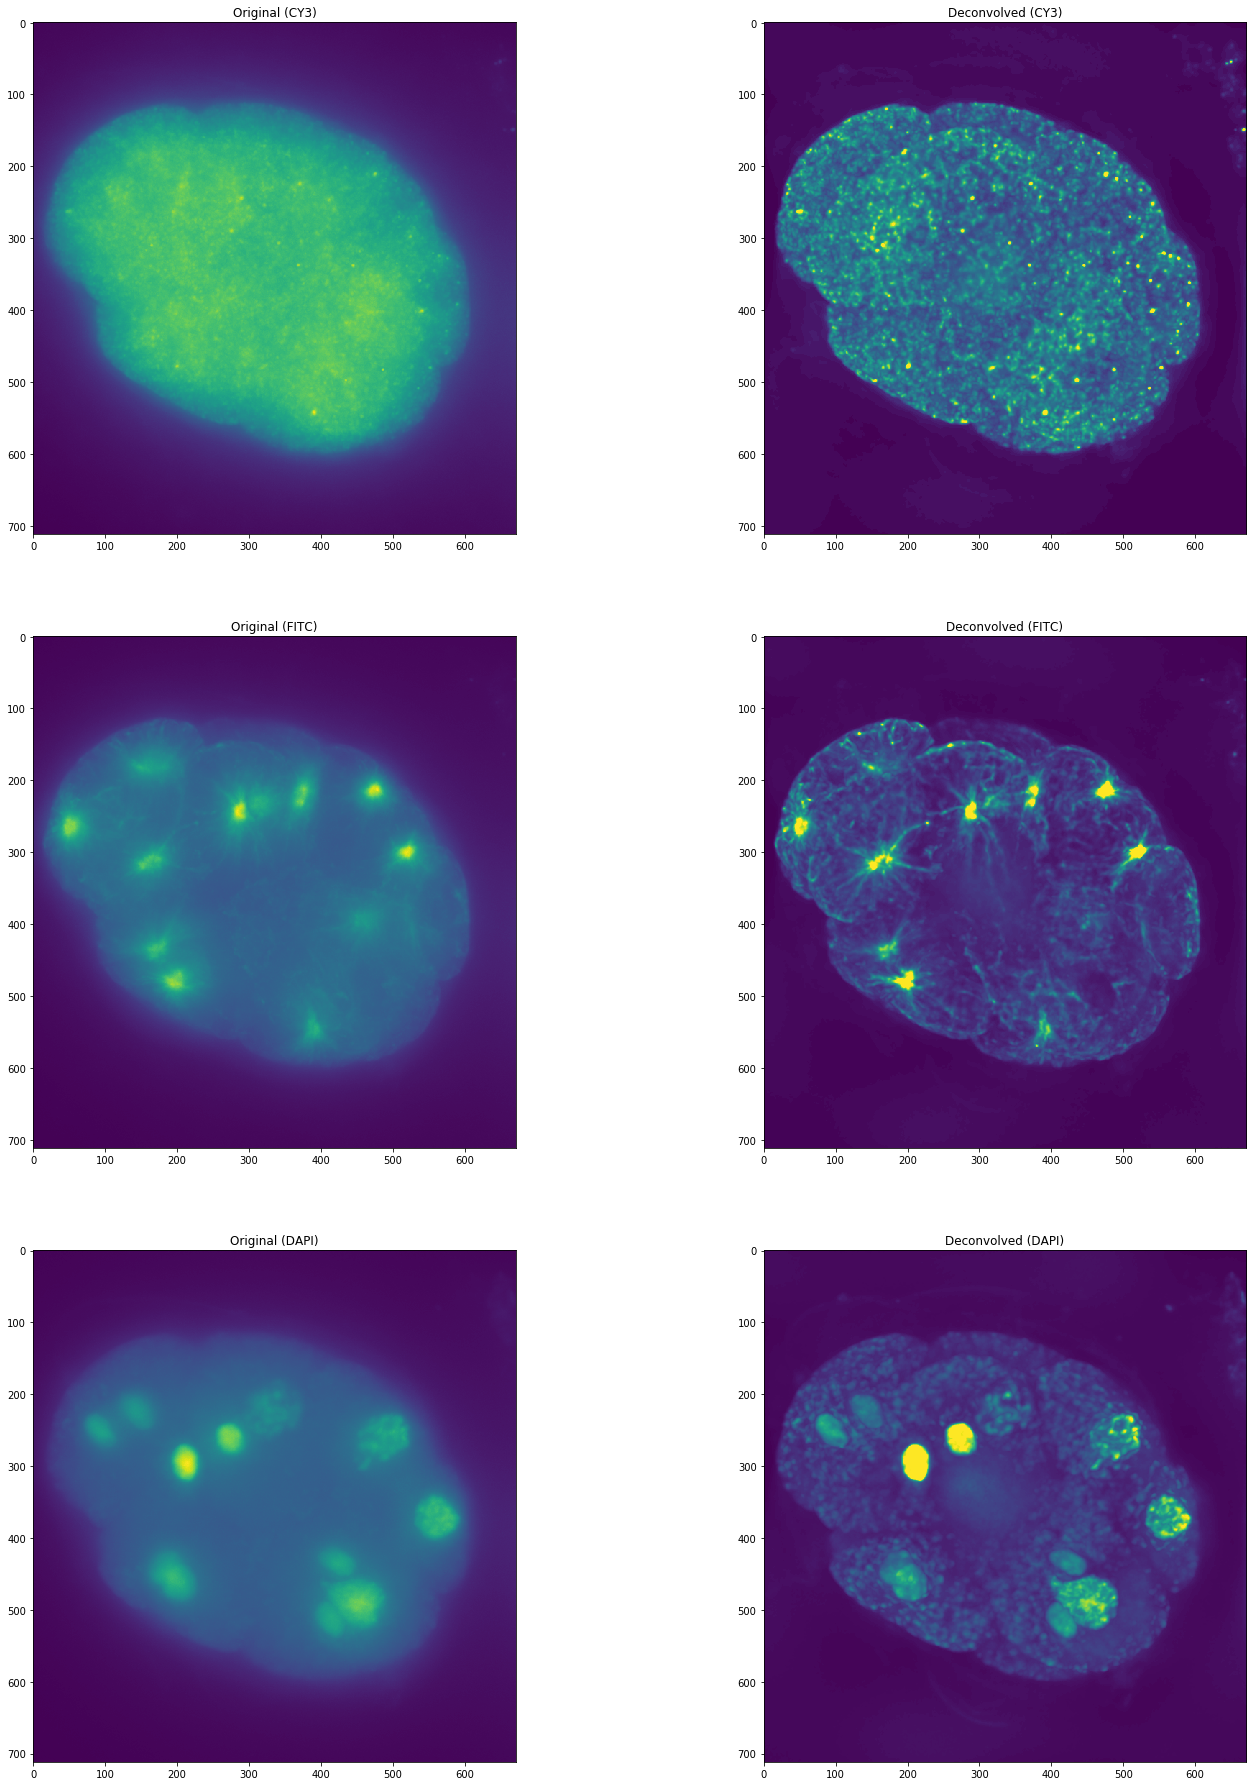

In [9]:
fig, axs = plt.subplots(len(channels), 2)
fig.set_size_inches((24, 32))

for i, ch in enumerate(channels):
    axs[i][0].imshow(img_acq[zslice, ..., i].max(axis=0))
    axs[i][0].set_title('Original ({})'.format(ch))
    axs[i][1].imshow(img_res[zslice, ..., i].clip(0, max_values[ch]).max(axis=0))
    axs[i][1].set_title('Deconvolved ({})'.format(ch))

In [10]:
def plot_img_slices(img, max_values=None):
    z = np.arange(zslice.start, zslice.stop, 5)
    fig, axs = plt.subplots(len(z), len(channels))
    fig.set_size_inches(len(channels)*6, len(z)*6)
    for i in range(len(z)):
        for j in range(len(acqs)):
            im = img[z[i], ..., j]
            if max_values is not None:
                im = im.clip(0, max_values[channels[j]])
            axs[i][j].imshow(im)
            axs[i][j].axis('off')
            axs[i][j].set_title('{} (z={})'.format(channels[j], z[i]))

<h2><center>Original Image Z Planes</center></h2>

Show individual 2D z plane images (over a selected range in the middle part of the volume) for each channel in the original image:

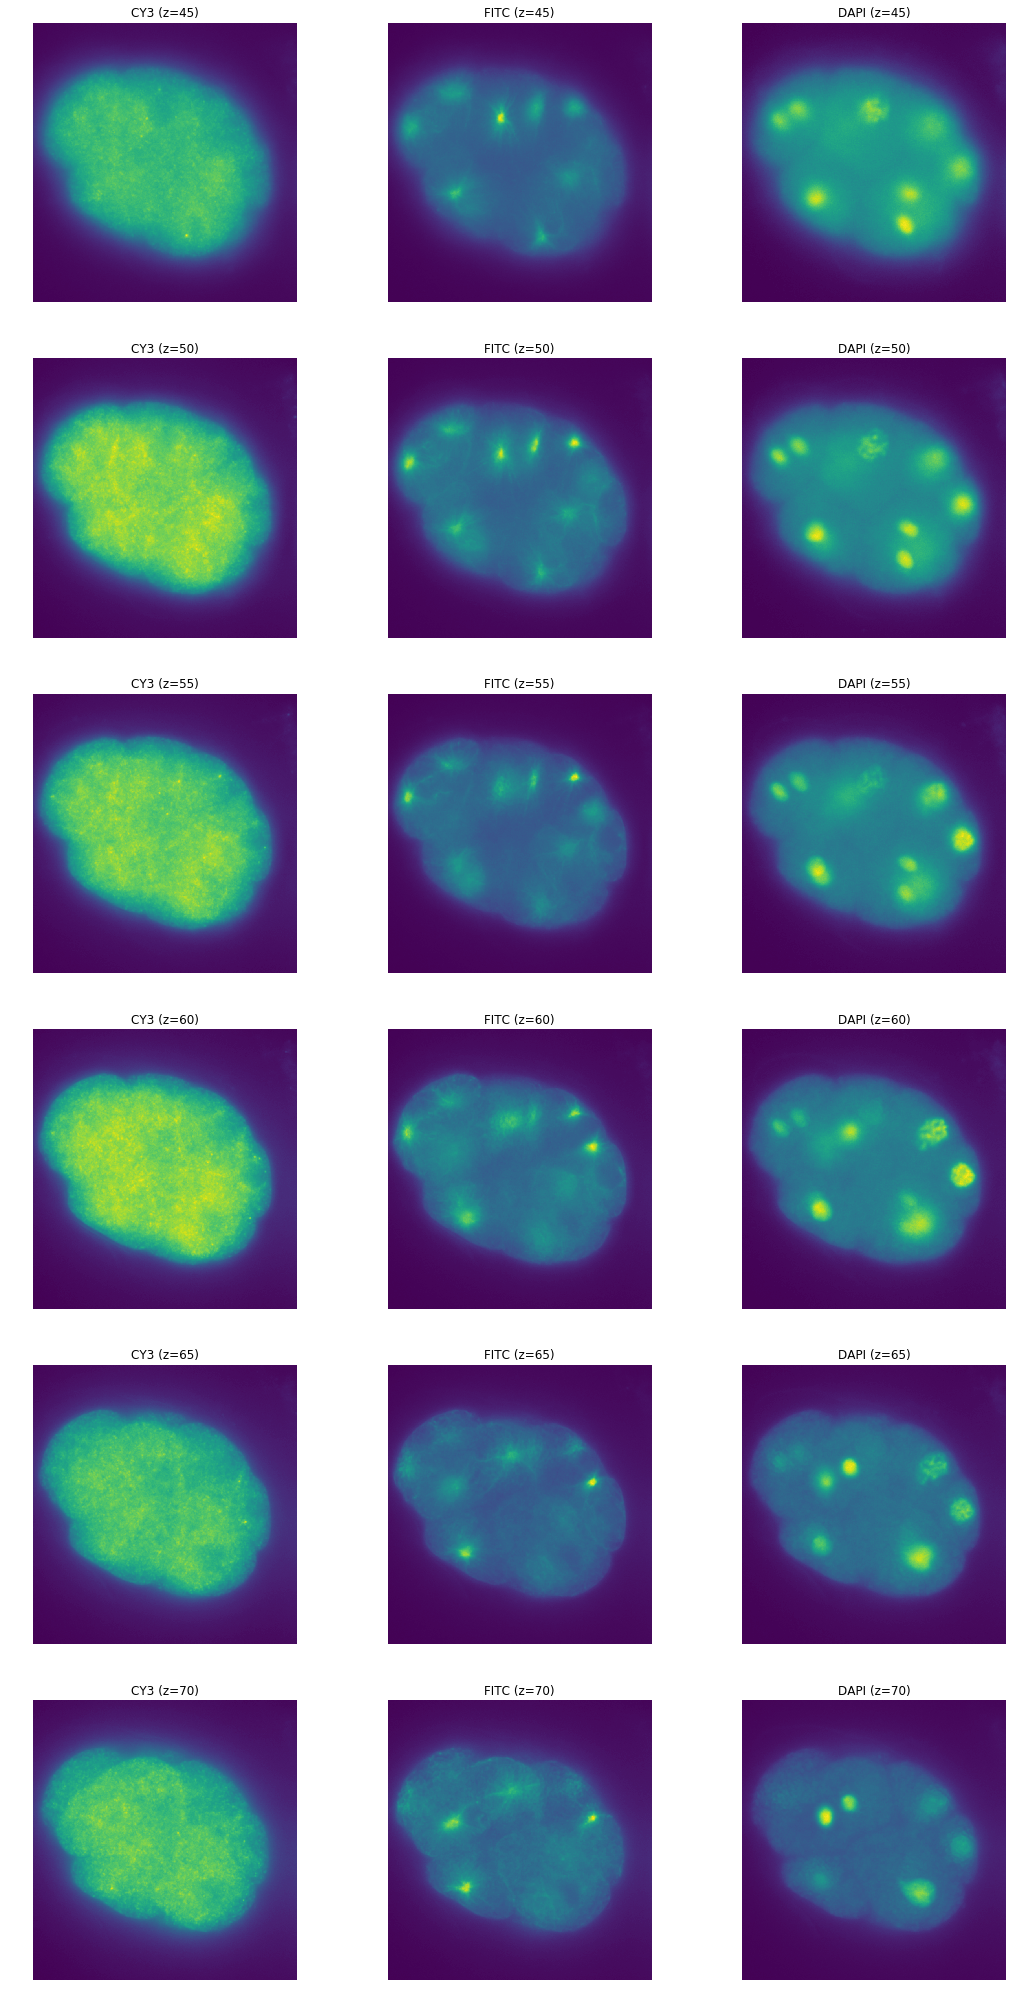

In [11]:
plot_img_slices(img_acq)

<h2><center>Deconvolved Image Z Planes</center></h2>

Same as above but with explicit contrast settings:

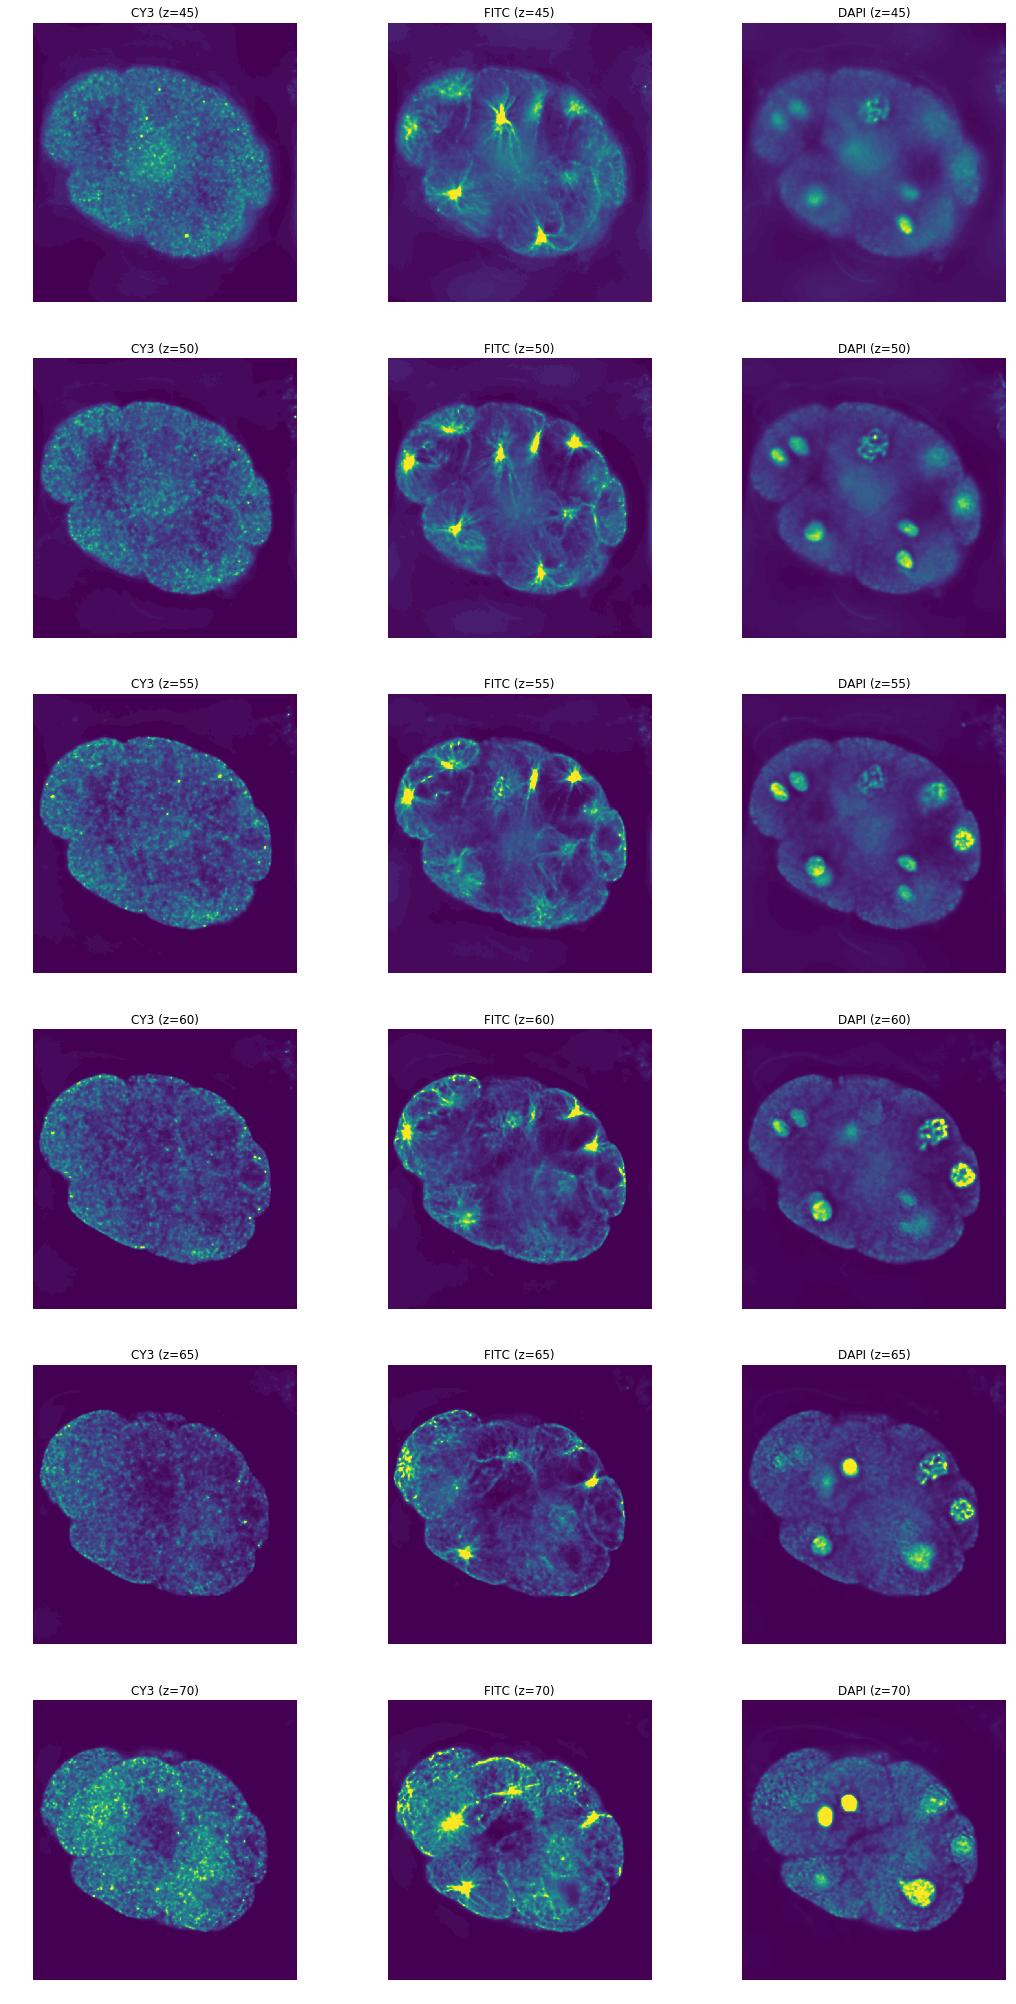

In [12]:
plot_img_slices(img_res, {'CY3': 40, 'FITC': 40, 'DAPI': 90})

## Export

This is one way to export these images to 5D hyperstacks for manipulation in ImageJ. This requires the ```tifffile``` package though which can be installed using ```pip install tifffile```:

In [13]:
from tifffile import imsave
# Save 5D arrays with shape (1, num_z_planes, channels, height, width)
imsave('/tmp/celegans-deconvolved.tif', np.moveaxis(img_res, -1, 1)[np.newaxis], imagej=True)
imsave('/tmp/celegans-original.tif', np.moveaxis(img_acq, -1, 1)[np.newaxis], imagej=True)